# Chain Graph with two clusters

This chain graph has two clusters $|C_1| = |C_2| = 100$.
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^10$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$ are 
generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. 

Intra-cluster edge weight equals 1. Inter-cluster edge weight eps is explored in this experiment.

In [11]:
def get_chain_data(cluster_sizes, w_true, m=5, n=2, noise_sd=0, is_torch_model=True):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = np.sum(cluster_sizes)
    E = N-1
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
   
    
    cnt = 0
    for i in range(E):
        B[cnt, i] = 1
        B[cnt, i+1] = -1

        cnt += 1
    B = B[:cnt, :]
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
            '''
            features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
            '''
            label = np.dot(features, w_true[i]) + np.random.normal(0,noise_sd)
            '''
            label: the label of the node i that is generated according to the linear model y = x^T w + e
            '''
            
            true_labels.append(label)

           
            
            datapoints[cnt] = {
                'features': features,
                'degree': node_degrees[cnt],
                'w': w_true[i],
                'label': label
            }
            cnt += 1

    return np.array(true_labels), datapoints


In [2]:
import cvxpy as cp
def run_cvxpy_chain(sampling_ratio=1,eps=0.1,penalty='norm1',lambda_lasso=1):
    true_labels, datapoints = get_chain_data(cluster_sizes,w_true=w_true,n=10,noise_sd=0.01, is_torch_model=False)
    num_nodes = sum(cluster_sizes)
    w = []
    for i in range(num_nodes):
        w += [cp.Variable(10)]

    obj = 0
    tv = 0
    if penalty=='norm1':
        for i in range(num_nodes-1):
            if i == cluster_sizes[0]-1:
                tv += eps*cp.norm(w[i]-w[i+1],1)
            else:
                tv += cp.norm(w[i]-w[i+1],1)
    elif penalty=='norm2':
        for i in range(num_nodes-1):
            if i == cluster_sizes[0]-1:
                tv += eps*cp.norm(w[i]-w[i+1],2)
            else:
                tv += cp.norm(w[i]-w[i+1],2)  
    elif penalty=='mocha':
        for i in range(num_nodes-1):
            if i == cluster_sizes[0]-1:
                tv += eps*cp.norm(w[i]-w[i+1],2)**2
            else:
                tv += cp.norm(w[i]-w[i+1],2)**2
   
    obj+=lambda_lasso*tv
 
    N = sum(cluster_sizes)
    samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))
    for i in samplingset:
        features = datapoints[i]['features']
        label = datapoints[i]['label']
        obj += cp.norm(cp.matmul(features, w[i])-label,2)
    obj = cp.Minimize(obj)
    prob = cp.Problem(obj)

    prob.solve()
     
    learned_w = []
    for v in prob.variables():
    #     print(type(variable.value))
        learned_w.append((v.value))
    learned_w = np.array(learned_w)
    
    score = get_algorithm1_w_MSE(datapoints, learned_w, samplingset)
    return [eps,penalty,score['total']]

In [9]:
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)

In [14]:
def get_algorithm1_w_MSE(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_w = []
    for i in range(len(datapoints)):
        true_w.append(datapoints[i]['w'])

    true_w = np.array(true_w)

#     alg1_MSE = {'total': mean_squared_error(true_w, predicted_w),
#                 'train': mean_squared_error(true_w[samplingset], predicted_w[samplingset]),
#                 'test': mean_squared_error(true_w[not_samplingset], predicted_w[not_samplingset])}
    
    alg1_MSE = {'total': mean_squared_error(true_w, predicted_w),
                'train': mean_squared_error(true_w[samplingset], predicted_w[samplingset])}

    return alg1_MSE

In [16]:
import numpy as np
import random
from sklearn.metrics import mean_squared_error


W1 = np.array([2 for i in range(10)])
'''
W1: the weigh vector for the first cluster
'''
W2 = np.array([-2 for i in range(5)]+[2 for i in range(5)])

w_true =[W1,W2]
cluster_sizes = [100,100]
run_cvxpy_chain(sampling_ratio=1,eps=0.1,penalty='norm1',lambda_lasso=0.1)

[0.1, 'norm1', 2.06526336223153e-05]

In [19]:
from joblib import Parallel, delayed
import multiprocessing
import csv

In [20]:
# sampling_ratios = [1]
PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']
cluster_sizes = [100,100]
W1 = np.array([2 for i in range(10)])
'''
W1: the weigh vector for the first cluster
'''
W2 = np.array([-2 for i in range(5)]+[2 for i in range(5)])

w_true =[W1,W2]
epses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.1,1.2]


num_tries = 10
# open the file in the write mode
f = open('results.csv', 'w',newline='')

# create the csv writer
writer = csv.writer(f)
header = ["eps","penalty","score"]
# write a row to the csv file
writer.writerow(header)



results = Parallel(n_jobs=1)(delayed(run_cvxpy_chain)(sampling_ratio=1,eps=eps,penalty=p,lambda_lasso=0.1)
                                             for eps in epses
                                             for p in PENALTY_FUNCS
                                             for t in range(num_tries))
for result in results:
    writer.writerow(result)
f.close()

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [24]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(results, columns=["eps","penalty","score"])

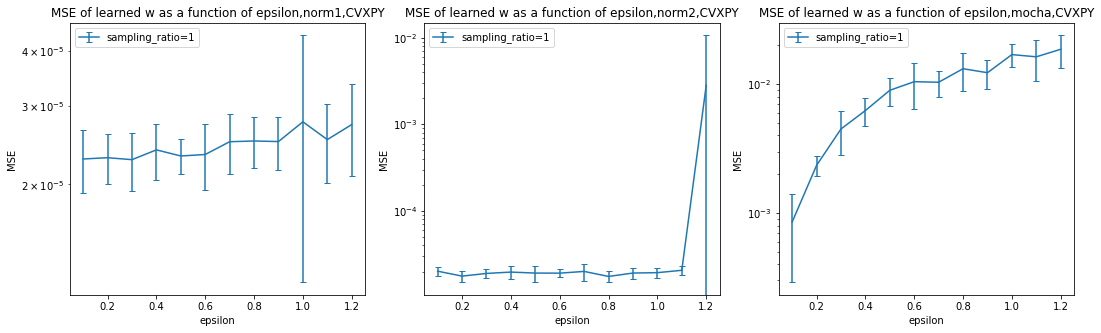

In [25]:
PENALTY_FUNCS= ['norm1', 'norm2', 'mocha']
# sampling_ratios = [0.2,0.4,0.6]
epses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.1,1.2]
colors = ['steelblue', 'darkorange', 'green', 'brown']
fig, axs = plt.subplots(1,3,figsize=(18,5))
for i in range(3):
        
    df_ = df[df.penalty==PENALTY_FUNCS[i]].groupby(by = ['eps']).aggregate(['mean','std'])

    axs[i].errorbar(df_.index, df_['score', 'mean'], yerr=df_['score', 'std'], 
                     capsize=3,
                     label='sampling_ratio=1')
    axs[i].legend(loc='best')
    axs[i].set_title('MSE of learned w as a function of epsilon,'+PENALTY_FUNCS[i]+',CVXPY')
    axs[i].set_xlabel('epsilon')
    axs[i].set_ylabel('MSE')

    axs[i].set_yscale('log')